# 0 Setup Environment

## 0.1 Import Libraries

In [1]:
# %pip install xgboost

In [2]:
# Data Manipulation and Visualization Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Statistics Libraries
from scipy.stats import randint

# Machine Learning Libraries
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

# Deep Learning
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Other Libraries
import pickle # Save and load DL models
from joblib import dump,load # Save and load ML models
import gc # Garbage collector to free storage

## 0.2 Load Dataset

In [3]:
collab = False # Set to True if running on Google Colab

In [4]:
# Scripts was initally used on collab and later on anther repository, so the data path is different
if collab:
    from google.colab import drive
    drive.mount('/content/drive')
    co2 = pd.read_csv("drive/MyDrive/co2 dataset/data_2021_CO2_Project_Fr_preprocessed.csv")
else:
    co2 = pd.read_csv("../data/data_2021_CO2_Project_Fr_preprocessed.csv")

## 0.3 EDA


In [5]:
# Get shape of dataset
co2.shape

(1589748, 31)

In [6]:
# Get list of columns for later use
n_unique = list()
for col in co2.columns:
  n_unique.append(co2[col].nunique())

# Get number of unique values per column
df_unique_values = pd.DataFrame({'column':co2.columns, 'count':n_unique})
df_unique_values

,column,count
0,Cr,2
1,m_kg,1063
2,Ewltp_g/km,328
3,W_mm,234
4,At1_mm,214
5,ec_cm3,98
6,ep_KW,164
7,z_Wh/km,222
8,IT,2
9,Erwltp_g/km,23


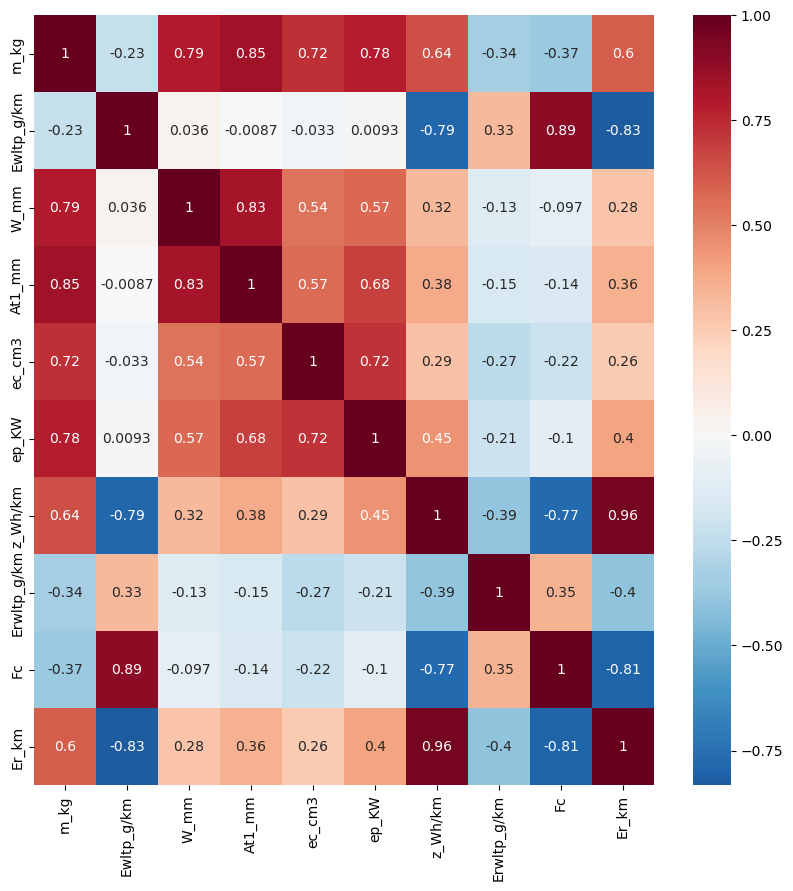

In [7]:
# Plot Heatmap of correlation between numeric columns
numeric_cols = df_unique_values[df_unique_values['count']>2].column # Use >2, because 2 the categorical features transormed with one-hot encoding to numeric

plt.figure(figsize=(10,10))
sns.heatmap(co2[numeric_cols].corr(),annot=True, cmap="RdBu_r", center =0)
plt.show()

# 1 Define methods

In [8]:
def get_evaluation_table(model,feat_train, feat_test,target_train, target_test):

  # Evalutaion on Training Set
  y_train_pred = model.predict(feat_train)
  train_rmse = mean_squared_error(target_train, y_train_pred, squared=False)
  train_mse = mean_squared_error(target_train, y_train_pred)
  train_mae = mean_absolute_error(target_train, y_train_pred)
  train_r2 = r2_score(target_train, y_train_pred)

  # Evalutaion on Test Set
  y_test_pred = model.predict(feat_test)
  test_rmse = mean_squared_error(target_test, y_test_pred, squared=False)
  test_mse = mean_squared_error(target_test, y_test_pred)
  test_mae = mean_absolute_error(target_test, y_test_pred)
  test_r2 = r2_score(target_test, y_test_pred)

  # Create table
  results = pd.DataFrame(
    index = ['MSE', 'RMSE', 'MAE', 'R2 Score'],
    data={'Training Set': [train_mse, train_rmse, train_mae, train_r2],
          'Test Set': [test_mse,test_rmse, test_mae, test_r2],
          'Delta': [test_mse-train_mse, test_rmse-train_rmse, test_mae-train_mae, test_r2-train_r2]})
  
  return results

In [9]:
def plot_feature_importance(model, feature_names, model_name, top_n=10):
    # Select and sort featue importance
    feature_importances = model.feature_importances_
    indices = feature_importances.argsort()[::-1][:top_n] 
    sorted_feature_names = [feature_names[i] for i in indices]
    top_n_feature_importances = feature_importances[indices]

    # Create dataframe
    df = pd.DataFrame({'Feature': sorted_feature_names, 'Importance': top_n_feature_importances})

    # Plot and use virdis color palette
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Importance', y='Feature', data=df, palette='viridis')
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.title(f'Top {top_n} Features - {model_name} Importance')
    plt.show()


In [10]:
def dl_plot_loss(history):
    plt.figure(figsize=(10,5))

    # Get the colors from 'viridis'
    viridis = sns.color_palette("viridis", 3)

    # Use the first color for 'loss' and the second color for 'val_loss'
    sns.lineplot(data=history.history['loss'], label='loss', color=viridis[0])
    sns.lineplot(data=history.history['val_loss'], label='val_loss', color=viridis[2])

    plt.ylim([0, 12])
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error [Ewltp_g/km]')
    plt.legend()

    plt.show()

In [11]:
def plot_feature_weights(model, columns):
    # Calculate realtive feature weights
    weights = model.get_layer('Dense').get_weights()[0]
    relative_weights = np.abs(weights.flatten()) / np.sum(np.abs(weights.flatten()))

    # Create Table with realtive weights and data.columns
    relative_weights = pd.DataFrame({'Feature':columns, 'Relative Weight':relative_weights})
    relative_weights = relative_weights.sort_values(by='Relative Weight', ascending=False)

    viridis = sns.color_palette("viridis", len(columns))

    # Plot the relative feature importance
    plt.figure(figsize=(15, 10))
    # plt.barh(relative_weights.Feature, relative_weights['Relative Weight'], color='skyblue')
    #plt.barh(relative_weights.Feature, relative_weights['Relative Weight'], palette='viridis')
    plt.barh(relative_weights.Feature, relative_weights['Relative Weight'], color=viridis)
    plt.xlabel('Feature Weight')
    plt.title('Relative Feature Importance')
    plt.show()

# 2 Regression

If train_models = False, the script will load the pre-trained models from the "models" folder. If it is set to True, the models will be trained again. Be carful as this will take a long time for GridSearch. 

In [12]:
train_models = False

## 2.1 Baseline Models (all features)

#### 2.1.1 Preprocessing

In [13]:
# Select data and target
data = co2.drop(['Ewltp_g/km'],axis=1)
target = co2['Ewltp_g/km']
gc.collect()

11132

count    1.589748e+06
mean     1.202319e+02
std      3.003297e+01
min      4.000000e+00
25%      1.150000e+02
50%      1.240000e+02
75%      1.350000e+02
max      3.730000e+02
Name: Ewltp_g/km, dtype: float64
Range:  369.0


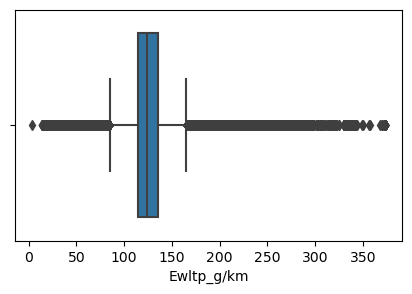

In [14]:
print(target.describe())
# range
range = target.max() - target.min()
print('Range: ',range)

# boxplot of target
plt.figure(figsize=(5,3))
sns.boxplot(x=target)
plt.show()


In [15]:
# Do Train Test Split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2,random_state=123)
gc.collect()

2931

### 2.1.2 Decision Tree Regression

In [16]:
# Train a naive Decision Tree
if train_models:
  dt_model = DecisionTreeRegressor(random_state=123)
  dt_model.fit(X_train, y_train)
  # Save model
  dump(dt_model, '../models/dt_model.joblib')

else:
  print("Only load model. Change variable train_models to True in chapter 1.0 if you want to retrain model.")

dt_model = load('../models/dt_model.joblib')

Only load model. Change variable train_models to True in chapter 1.0 if you want to retrain model.


In [17]:
results_dt = get_evaluation_table(dt_model,X_train,X_test,y_train,y_test)
print(results_dt)

          Training Set  Test Set     Delta
MSE           0.664020  0.800427  0.136407
RMSE          0.814874  0.894666  0.079791
MAE           0.393240  0.405307  0.012067
R2 Score      0.999265  0.999109 -0.000156


### 2.1.3 Random Forest Regression

In [18]:
# Train a Random Forest Regression
if train_models:
  # Train model
  rf_model = RandomForestRegressor(random_state=123)
  rf_model.fit(X_train, y_train)
  # Save model
  dump(rf_model, '../models/rf_model.joblib')

else:
  print("Only load model. Change variable train_models to True in chapter 1.0 if you want to retrain model.")

rf_model = load('../models/rf_model.joblib')

Only load model. Change variable train_models to True in chapter 1.0 if you want to retrain model.


In [19]:
results_rf = get_evaluation_table(rf_model,X_train,X_test,y_train,y_test)
print(results_rf)

          Training Set  Test Set     Delta
MSE           0.680387  0.798745  0.118358
RMSE          0.824856  0.893725  0.068870
MAE           0.396569  0.406699  0.010130
R2 Score      0.999246  0.999111 -0.000136


### 2.1.4 XGBoost Regression

In [20]:
# Train a XGBoost Regression
if train_models:
  # Train model
  xgb_model = XGBRegressor()
  xgb_model.fit(X_train, y_train)
  # Save model
  dump(xgb_model, '../models/xgb_model.joblib')

else:
  print("Only load model. Change variable train_models to True in chapter 1.0 if you want to retrain model.")

# Load model
xgb_model = load('../models/xgb_model.joblib')

Only load model. Change variable train_models to True in chapter 1.0 if you want to retrain model.


In [21]:
results_xgb = get_evaluation_table(xgb_model,X_train,X_test,y_train,y_test)
print(results_xgb)

          Training Set  Test Set     Delta
MSE           1.742647  1.878606  0.135959
RMSE          1.320093  1.370622  0.050529
MAE           0.736262  0.741925  0.005663
R2 Score      0.998070  0.997908 -0.000162


### 2.1.5 Store results

In [22]:
# Predict Train and Test Set
y_pred_xgbr_train = xgb_model.predict(X_train)
y_pred_xgbr_test = xgb_model.predict(X_test)
y_pred_dt_train = dt_model.predict(X_train)
y_pred_dt_test = dt_model.predict(X_test)
y_pred_rf_train = rf_model.predict(X_train)
y_pred_rf_test = rf_model.predict(X_test)

# Create and fit the naive regressor
naive_regressor = DummyRegressor(strategy='mean')
naive_regressor.fit(X_train, y_train)
y_pred_naive_train = naive_regressor.predict(X_train)
y_pred_naive_test = naive_regressor.predict(X_test)

# Compare results with dummy regressor
results = {
    'Model': ['XGBoost Regressor', 'Decision Tree Regressor', 'Random Forest Regressor', 'Naive Regressor'],
    'RMSE (Train)': [np.sqrt(mean_squared_error(y_train, y_pred_xgbr_train)),
                     np.sqrt(mean_squared_error(y_train, y_pred_dt_train)),
                     np.sqrt(mean_squared_error(y_train, y_pred_rf_train)),
                     np.sqrt(mean_squared_error(y_train, y_pred_naive_train))],
    'RMSE (Test)': [np.sqrt(mean_squared_error(y_test, y_pred_xgbr_test)),
                    np.sqrt(mean_squared_error(y_test, y_pred_dt_test)),
                    np.sqrt(mean_squared_error(y_test, y_pred_rf_test)),
                    np.sqrt(mean_squared_error(y_test, y_pred_naive_test))],
    'MSE (Train)': [mean_squared_error(y_train, y_pred_xgbr_train),
                    mean_squared_error(y_train, y_pred_dt_train),
                    mean_squared_error(y_train, y_pred_rf_train),
                    mean_squared_error(y_train, y_pred_naive_train)],
    'MSE (Test)': [mean_squared_error(y_test, y_pred_xgbr_test),
                   mean_squared_error(y_test, y_pred_dt_test),
                   mean_squared_error(y_test, y_pred_rf_test),
                   mean_squared_error(y_test, y_pred_naive_test)],
    'MAE (Train)': [mean_absolute_error(y_train, y_pred_xgbr_train),
                    mean_absolute_error(y_train, y_pred_dt_train),
                    mean_absolute_error(y_train, y_pred_rf_train),
                    mean_absolute_error(y_train, y_pred_naive_train)],
    'MAE (Test)': [mean_absolute_error(y_test, y_pred_xgbr_test),
                   mean_absolute_error(y_test, y_pred_dt_test),
                   mean_absolute_error(y_test, y_pred_rf_test),
                   mean_absolute_error(y_test, y_pred_naive_test)],
    'R^2 (Train)': [r2_score(y_train, y_pred_xgbr_train),
                    r2_score(y_train, y_pred_dt_train),
                    r2_score(y_train, y_pred_rf_train),
                    r2_score(y_train, y_pred_naive_train)],
    'R^2 (Test)': [r2_score(y_test, y_pred_xgbr_test),
                   r2_score(y_test, y_pred_dt_test),
                   r2_score(y_test, y_pred_rf_test),
                   r2_score(y_test, y_pred_naive_test)]
}
results = pd.DataFrame(results)


In [23]:
# Compare Models
print(results[['Model','RMSE (Test)','R^2 (Test)']])
# All regression models perform very good compared to the naive regressor

                     Model  RMSE (Test)    R^2 (Test)
0        XGBoost Regressor     1.370622  9.979083e-01
1  Decision Tree Regressor     0.894666  9.991088e-01
2  Random Forest Regressor     0.893725  9.991107e-01
3          Naive Regressor    29.968921 -5.477492e-07


In [24]:
# Check for overfitting
print(results[['Model','RMSE (Test)','RMSE (Train)','R^2 (Test)','R^2 (Train)']])

                     Model  RMSE (Test)  RMSE (Train)    R^2 (Test)  \
0        XGBoost Regressor     1.370622      1.320093  9.979083e-01   
1  Decision Tree Regressor     0.894666      0.814874  9.991088e-01   
2  Random Forest Regressor     0.893725      0.824856  9.991107e-01   
3          Naive Regressor    29.968921     30.048950 -5.477492e-07   

   R^2 (Train)  
0     0.998070  
1     0.999265  
2     0.999246  
3     0.000000  


### 2.1.6 Show Feature Importance

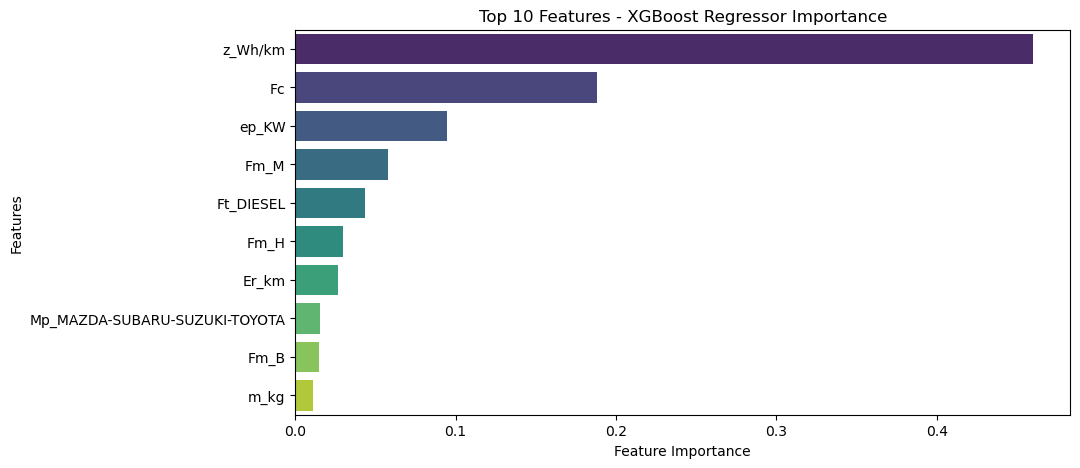

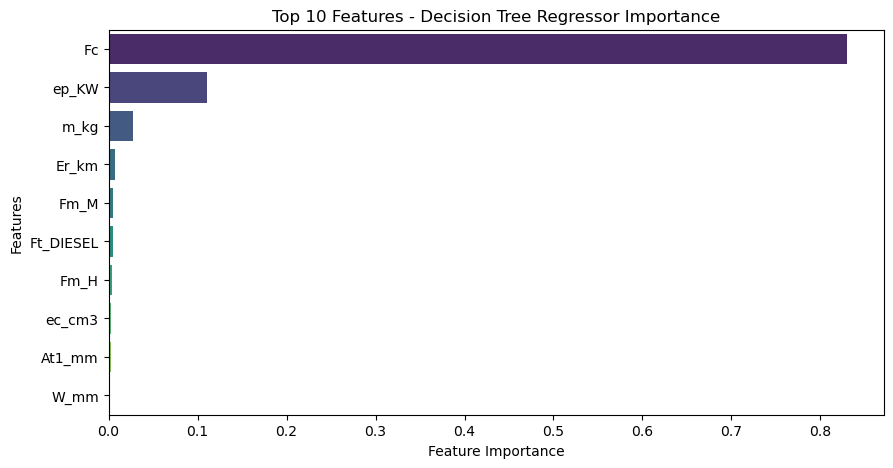

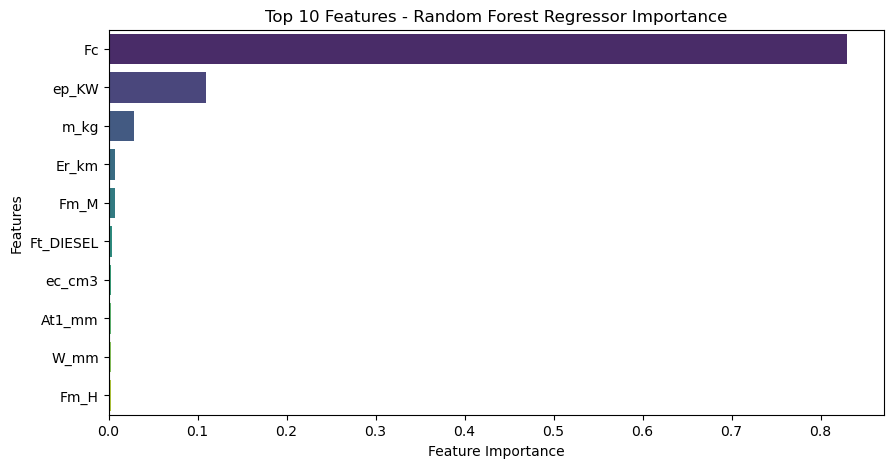

In [25]:
# Plot Feature importance
plot_feature_importance(xgb_model, X_train.columns, 'XGBoost Regressor')
plot_feature_importance(dt_model, X_train.columns, 'Decision Tree Regressor')
plot_feature_importance(rf_model, X_train.columns, 'Random Forest Regressor')

### 2.1.7 Analyze relationship between Er, Fc and target

As another project, it would be interessting to figure out which variables are confounding with the relationship between Fc and co2 emissions with cluster analysis. However, we decided not to do this in the scope of the project, as our focus lies on the prediction of CO2 emission.

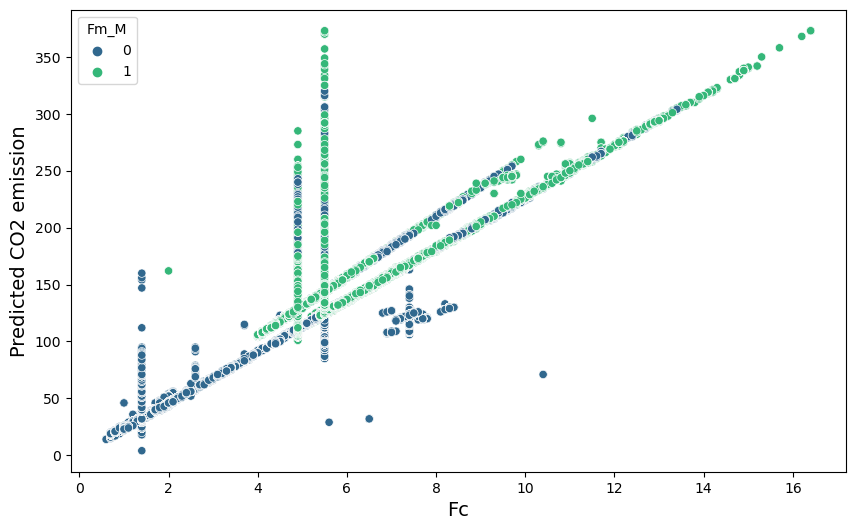

In [26]:
# Create scatterplot using Seaborn
plt.figure(figsize=(10, 6))  # Set figure size
sns.scatterplot(x=co2['Fc'], y=co2['Ewltp_g/km'], hue=co2['Fm_M'], palette='viridis')

# Set plot title and labels
plt.xlabel('Fc', fontsize=14)
plt.ylabel('Predicted CO2 emission', fontsize=14)

# Show the plot
plt.show()

## 2.2 Baseline Models (drop Fuel Consumption and Electric Range)

### 2.2.1 Preprocessing

In [27]:
# Select data and target
data = co2.drop(['Ewltp_g/km','Fc','Er_km'],axis=1)
target = co2['Ewltp_g/km']
gc.collect()

8449

In [28]:
# Do Train Test Split
X_train_wo_fc, X_test_wo_fc, y_train_wo_fc, y_test_wo_fc = train_test_split(data, target, test_size = 0.2,random_state=123)
gc.collect()

3805

In [29]:
# Store for streamlit
# dump((X_train_wo_fc, X_test_wo_fc, y_train_wo_fc, y_test_wo_fc), 'train_test_split.pkl')

### 2.2.2 Decision Tree Regression

In [30]:
# Train a Decision Tree Regression
if train_models:
  # Train model
  dt_model_wo_fc = DecisionTreeRegressor(random_state=123)
  dt_model_wo_fc.fit(X_train_wo_fc, y_train_wo_fc)
  # Save model
  dump(dt_model_wo_fc, '../models/dt_model_wo_fc.joblib')

else:
  print("Only load model. Change variable train_models to True in chapter 1.0 if you want to retrain model.")

# Load model
dt_model_wo_fc = load('../models/dt_model_wo_fc.joblib')

Only load model. Change variable train_models to True in chapter 1.0 if you want to retrain model.


In [31]:
results_dt_wo_fc = get_evaluation_table(dt_model_wo_fc,X_train_wo_fc,X_test_wo_fc, y_train_wo_fc, y_test_wo_fc  )
print(results_dt_wo_fc)

# save dataframe as csv
# results_dt_wo_fc.to_csv('results/tables/results_dt_wo_fc.csv', index=True, sep=';',float_format='%.3f')

          Training Set  Test Set     Delta
MSE           2.626929  2.778597  0.151668
RMSE          1.620780  1.666913  0.046132
MAE           0.930077  0.937710  0.007633
R2 Score      0.997091  0.996906 -0.000184


In [32]:
# Store results with pickle for streamlit import
with open('../models/results_dtr.pkl', 'wb') as f:
    pickle.dump(results_dt_wo_fc.round(2), f)

### 2.2.3 Random Forest Regression

In [33]:
# Train a Random Forest Regression
if train_models:
  # Train model
  rf_model_wo_fc = RandomForestRegressor(random_state=123)
  rf_model_wo_fc.fit(X_train_wo_fc, y_train)
  # Save model
  dump(rf_model_wo_fc, '../models/rf_model_wo_fc.joblib')

else:
  print("Only load model. Change variable train_models to True in chapter 1.0 if you want to retrain model.")

# Load model
rf_model_wo_fc = load('../models/rf_model_wo_fc.joblib')

Only load model. Change variable train_models to True in chapter 1.0 if you want to retrain model.


In [34]:
results_rf_wo_fc = get_evaluation_table(rf_model_wo_fc,X_train_wo_fc,X_test_wo_fc, y_train_wo_fc, y_test_wo_fc)
print(results_rf_wo_fc)

# save dataframe as csv
# results_rf_wo_fc.to_csv('results/tables/results_rf_wo_fc.csv', index=True, sep=';',float_format='%.3f')

          Training Set  Test Set     Delta
MSE           2.639201  2.767497  0.128295
RMSE          1.624562  1.663579  0.039018
MAE           0.932556  0.938309  0.005754
R2 Score      0.997077  0.996919 -0.000158


In [35]:
# Store results with pickle for streamlit import
with open('../models/results_rfr.pkl', 'wb') as f:
    pickle.dump(results_rf_wo_fc.round(2), f)

### 2.2.4 XGBoost Regression

In [36]:
# Train a XGBoost Regression
if train_models:
  # Train model
  xgb_model_wo_fc = XGBRegressor(random_state=123)
  xgb_model_wo_fc.fit(X_train_wo_fc, y_train_wo_fc)
  # Save model
  dump(xgb_model_wo_fc, '../models/xgb_model_wo_fc.joblib')

else:
  print("Only load model. Change variable train_models to True in chapter 1.0 if you want to retrain model.")

# Load model
xgb_model_wo_fc = load('../models/xgb_model_wo_fc.joblib')

Only load model. Change variable train_models to True in chapter 1.0 if you want to retrain model.


In [37]:
results_xgb_wo_fc = get_evaluation_table(xgb_model_wo_fc,X_train_wo_fc,X_test_wo_fc, y_train_wo_fc, y_test_wo_fc)
print(results_xgb_wo_fc)

# save dataframe as csv
# results_xgb_wo_fc.to_csv('results/tables/results_xgb_wo_fc.csv', index=True, sep=';',float_format='%.3f')

          Training Set  Test Set     Delta
MSE           4.197077  4.305273  0.108196
RMSE          2.048677  2.074915  0.026238
MAE           1.288503  1.289756  0.001254
R2 Score      0.995352  0.995206 -0.000145


In [38]:
# Store results with pickle for streamlit import
with open('../models/results_xgbr.pkl', 'wb') as f:
    pickle.dump(results_xgb_wo_fc.round(2), f)

### 2.2.5 Store Results

In [39]:
# Predict Train and Test Set
y_pred_xgbr_train_wo_fc = xgb_model_wo_fc.predict(X_train_wo_fc)
y_pred_xgbr_test_wo_fc = xgb_model_wo_fc.predict(X_test_wo_fc)
y_pred_dt_train_wo_fc = dt_model_wo_fc.predict(X_train_wo_fc)
y_pred_dt_test_wo_fc = dt_model_wo_fc.predict(X_test_wo_fc)
y_pred_rf_train_wo_fc = rf_model_wo_fc.predict(X_train_wo_fc)
y_pred_rf_test_wo_fc = rf_model_wo_fc.predict(X_test_wo_fc)

# Create and fit the naive regressor
naive_regressor_wo_fc = DummyRegressor(strategy='mean')
naive_regressor_wo_fc.fit(X_train_wo_fc, y_train_wo_fc)
y_pred_naive_train_wo_fc = naive_regressor.predict(X_train_wo_fc)
y_pred_naive_test_wo_fc = naive_regressor.predict(X_test_wo_fc)

# Compare results with dummy regressor
results_wo_fc = {
    'Model': ['XGBoost Regressor (w\o fc)', 'Decision Tree Regressor (w\o fc)', 'Random Forest Regressor (w\o fc)', 'Naive Regressor (w\o fc)'],
    'RMSE (Train)': [np.sqrt(mean_squared_error(y_train_wo_fc, y_pred_xgbr_train_wo_fc)),
                     np.sqrt(mean_squared_error(y_train_wo_fc, y_pred_dt_train_wo_fc)),
                     np.sqrt(mean_squared_error(y_train_wo_fc, y_pred_rf_train_wo_fc)),
                     np.sqrt(mean_squared_error(y_train_wo_fc, y_pred_naive_train_wo_fc))],
    'RMSE (Test)': [np.sqrt(mean_squared_error(y_test_wo_fc, y_pred_xgbr_test_wo_fc)),
                    np.sqrt(mean_squared_error(y_test_wo_fc, y_pred_dt_test_wo_fc)),
                    np.sqrt(mean_squared_error(y_test_wo_fc, y_pred_rf_test_wo_fc)),
                    np.sqrt(mean_squared_error(y_test_wo_fc, y_pred_naive_test_wo_fc))],
    'MSE (Train)': [mean_squared_error(y_train_wo_fc, y_pred_xgbr_train_wo_fc),
                    mean_squared_error(y_train_wo_fc, y_pred_dt_train_wo_fc),
                    mean_squared_error(y_train_wo_fc, y_pred_rf_train_wo_fc),
                    mean_squared_error(y_train_wo_fc, y_pred_naive_train_wo_fc)],
    'MSE (Test)': [mean_squared_error(y_test_wo_fc, y_pred_xgbr_test_wo_fc),
                   mean_squared_error(y_test_wo_fc, y_pred_dt_test_wo_fc),
                   mean_squared_error(y_test_wo_fc, y_pred_rf_test_wo_fc),
                   mean_squared_error(y_test_wo_fc, y_pred_naive_test_wo_fc)],
    'MAE (Train)': [mean_absolute_error(y_train_wo_fc, y_pred_xgbr_train_wo_fc),
                    mean_absolute_error(y_train_wo_fc, y_pred_dt_train_wo_fc),
                    mean_absolute_error(y_train_wo_fc, y_pred_rf_train_wo_fc),
                    mean_absolute_error(y_train_wo_fc, y_pred_naive_train_wo_fc)],
    'MAE (Test)': [mean_absolute_error(y_test_wo_fc, y_pred_xgbr_test_wo_fc),
                   mean_absolute_error(y_test_wo_fc, y_pred_dt_test_wo_fc),
                   mean_absolute_error(y_test_wo_fc, y_pred_rf_test_wo_fc),
                   mean_absolute_error(y_test_wo_fc, y_pred_naive_test_wo_fc)],
    'R^2 (Train)': [r2_score(y_train_wo_fc, y_pred_xgbr_train_wo_fc),
                    r2_score(y_train_wo_fc, y_pred_dt_train_wo_fc),
                    r2_score(y_train_wo_fc, y_pred_rf_train_wo_fc),
                    r2_score(y_train_wo_fc, y_pred_naive_train_wo_fc)],
    'R^2 (Test)': [r2_score(y_test_wo_fc, y_pred_xgbr_test_wo_fc),
                   r2_score(y_test_wo_fc, y_pred_dt_test_wo_fc),
                   r2_score(y_test_wo_fc, y_pred_rf_test_wo_fc),
                   r2_score(y_test_wo_fc, y_pred_naive_test_wo_fc)]
}
results_wo_fc = pd.DataFrame(results_wo_fc)


In [40]:
results_combined = pd.concat([results,results_wo_fc])
display(results_combined)

,Model,RMSE (Train),RMSE (Test),MSE (Train),MSE (Test),MAE (Train),MAE (Test),R^2 (Train),R^2 (Test)
0,XGBoost Regressor,1.320093,1.370622,1.742647,1.878606,0.736262,0.741925,0.998070,9.979083e-01
1,Decision Tree Regressor,0.814874,0.894666,0.664020,0.800427,0.393240,0.405307,0.999265,9.991088e-01
2,Random Forest Regressor,0.824856,0.893725,0.680387,0.798745,0.396569,0.406699,0.999246,9.991107e-01
3,Naive Regressor,30.048950,29.968921,902.939401,898.136239,18.870183,18.830497,0.000000,-5.477492e-07
0,XGBoost Regressor (w\o fc),2.048677,2.074915,4.197077,4.305273,1.288503,1.289756,0.995352,9.952064e-01
1,Decision Tree Regressor (w\o fc),1.620780,1.666913,2.626929,2.778597,0.930077,0.937710,0.997091,9.969063e-01
2,Random Forest Regressor (w\o fc),1.624562,1.663579,2.639201,2.767497,0.932556,0.938309,0.997077,9.969186e-01
3,Naive Regressor (w\o fc),30.048950,29.968921,902.939401,898.136239,18.870183,18.830497,0.000000,-5.477492e-07


In [41]:
results_combined["RMSE (Test-Train)"] = results_combined["RMSE (Test)"] - results_combined["RMSE (Train)"]
results_combined["MSE (Test-Train)"] = results_combined["MSE (Test)"] - results_combined["MSE (Train)"]
results_combined["MAE (Test-Train)"] = results_combined["MAE (Test)"] - results_combined["MAE (Train)"]
results_combined["R^2 (Train-Test)"] = results_combined["R^2 (Train)"] - results_combined["R^2 (Test)"]


In [42]:
# reorder rows
results_combined = results_combined.iloc[[0,4,1,5,2,6,3,7]]

# Set Index
results_combined=results_combined.set_index(['Model'])

# Reorder Columns
results_combined = results_combined.iloc[:,[0,1,8,2,3,9,4,5,10,6,7,11]]

#### With and without fc and er

In [43]:
results_combined.iloc[:,[1,2,10,11]]

,RMSE (Test),RMSE (Test-Train),R^2 (Test),R^2 (Train-Test)
Model,,,,
XGBoost Regressor,1.370622,0.050529,9.979083e-01,1.617020e-04
XGBoost Regressor (w\o fc),2.074915,0.026238,9.952064e-01,1.453278e-04
Decision Tree Regressor,0.894666,0.079791,9.991088e-01,1.558109e-04
Decision Tree Regressor (w\o fc),1.666913,0.046132,9.969063e-01,1.844307e-04
Random Forest Regressor,0.893725,0.068870,9.991107e-01,1.358121e-04
Random Forest Regressor (w\o fc),1.663579,0.039018,9.969186e-01,1.584795e-04
Naive Regressor,29.968921,-0.080029,-5.477492e-07,5.477492e-07
Naive Regressor (w\o fc),29.968921,-0.080029,-5.477492e-07,5.477492e-07


#### Only without fc and er

In [44]:
results_combined.iloc[[1,3,5,7],[1,2,10,11]]

,RMSE (Test),RMSE (Test-Train),R^2 (Test),R^2 (Train-Test)
Model,,,,
XGBoost Regressor (w\o fc),2.074915,0.026238,9.952064e-01,1.453278e-04
Decision Tree Regressor (w\o fc),1.666913,0.046132,9.969063e-01,1.844307e-04
Random Forest Regressor (w\o fc),1.663579,0.039018,9.969186e-01,1.584795e-04
Naive Regressor (w\o fc),29.968921,-0.080029,-5.477492e-07,5.477492e-07


I'd choose Random Forest Regressor, because it performs better than XGB. It perdorms similar to DT, but slightly better with less overfitting. Also DT places a big importance to one feature (Er_km with 70%)

### 2.2.6 Show Feature imporatnce

Just a quick overview. The final model interpretation is in chapter 6.

#### XGBoost

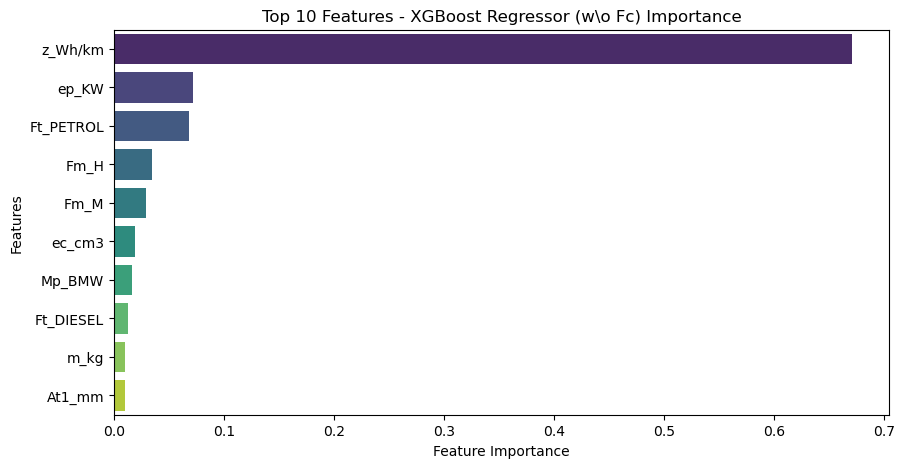

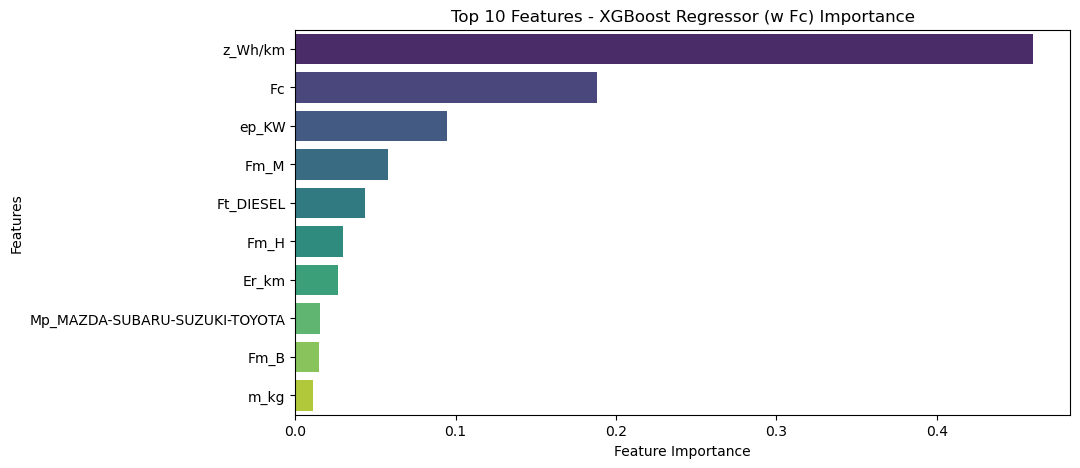

In [45]:
plot_feature_importance(xgb_model_wo_fc, X_train_wo_fc.columns, 'XGBoost Regressor (w\o Fc)')
plot_feature_importance(xgb_model, X_train.columns, 'XGBoost Regressor (w Fc)')

#### Decision Tree

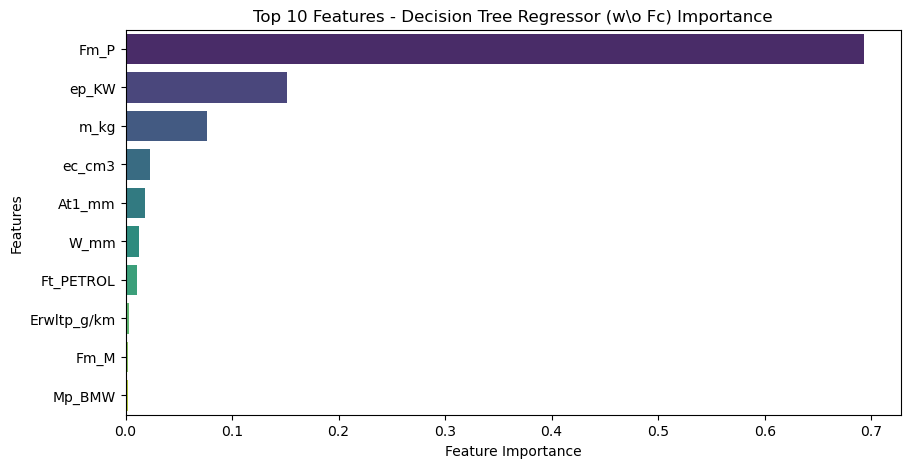

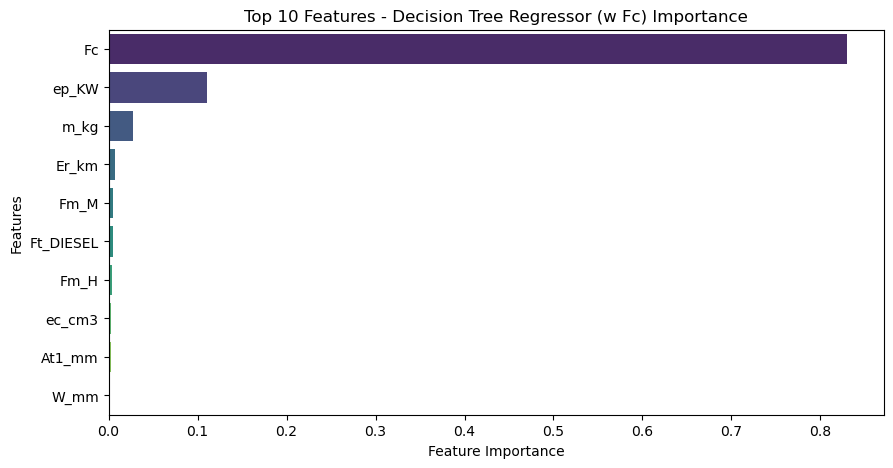

In [46]:
plot_feature_importance(dt_model_wo_fc, X_train_wo_fc.columns, 'Decision Tree Regressor (w\o Fc)')
plot_feature_importance(dt_model, X_train.columns, 'Decision Tree Regressor (w Fc)')

In [47]:
# Create dataframe with feature names and feature importances of dt_model
feature_importances_dt = pd.DataFrame({'feature':X_train.columns,'importance':dt_model.feature_importances_})

# Sort values by importance
feature_importances_dt = feature_importances_dt.sort_values('importance',ascending=False).reset_index(drop=True)

# Add column with cumulative sum of feature importances
feature_importances_dt['cumsum'] = feature_importances_dt['importance'].cumsum()
display(feature_importances_dt)

,feature,importance,cumsum
0,Fc,8.293737e-01,0.829374
1,ep_KW,1.108764e-01,0.940250
2,m_kg,2.695256e-02,0.967203
3,Er_km,6.993825e-03,0.974197
4,Fm_M,5.492235e-03,0.979689
5,Ft_DIESEL,4.752586e-03,0.984441
6,Fm_H,3.431326e-03,0.987873
7,ec_cm3,3.138744e-03,0.991011
8,At1_mm,2.278405e-03,0.993290
9,W_mm,2.139991e-03,0.995430


#### Random Forest

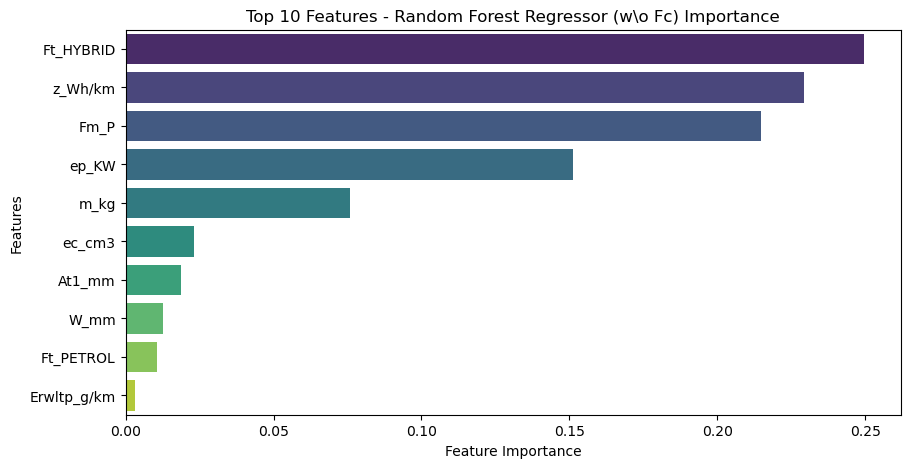

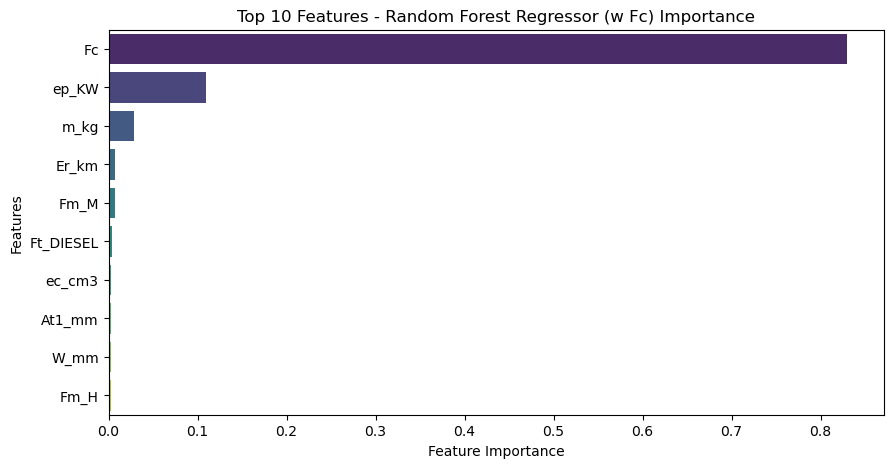

In [48]:
plot_feature_importance(rf_model_wo_fc, X_train_wo_fc.columns, 'Random Forest Regressor (w\o Fc)')
plot_feature_importance(rf_model, X_train.columns, 'Random Forest Regressor (w Fc)')

# 3 Deep Learning

## 3.1 Preprocessing

Use data without Fuel Consumption and Electric Range

In [49]:
# Use same data and target as before in chapter 1.2
data = data
print(data.shape)

target = target
print(target.shape)

(1589748, 28)
(1589748,)


Deep Learning is sensitive to the scale of input features. Therefore we'll scale the data using StandardScaler, because we don't want to have negative values as this could be irritating during model interpreation.

In [50]:
# Train Test Split
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(data, target, test_size=0.2,random_state=123)

# Use MinMaxScaler to scale data
scaler = MinMaxScaler()
X_train_dl = scaler.fit_transform(X_train_dl)
X_test_dl = scaler.transform(X_test_dl)

## 3.2 Linear Model

### 3.2.1 Built Model

In [51]:
if train_models:
    'Step 1: Load the packages'
    # Done above

    'Step 2: Initialize the input layer'
    inputs = Input(shape = X_train_dl.shape[1], name = "Input")

    'Step 3: Initialize the layers'
    dense = Dense(units=1, name='Dense')

    'Step 4: Apply the layers one by one (functional construction' 
    outputs = dense(inputs)

    'Step 5: Finalize model and show structure'
    linear_model = Model(inputs = inputs, outputs = outputs)
    linear_model.summary()

    'Step 6: Compile Model with optimizer, loss and metrics'
    opt = tf.optimizers.Adam(learning_rate=0.01)
    linear_model.compile(loss = "mean_absolute_error",
                  optimizer = opt)

    training_history = linear_model.fit(X_train_dl, 
                                        y_train_dl,
                                        epochs=50,
                                        batch_size=32,
                                        validation_split=0.2)

    'Step 7: Save Model'
    dump(linear_model, '../models/linear_model.joblib')

    'Step 8: Save training history'
    with open('../models/training_history_linear_model', 'wb') as file:
        pickle.dump(training_history, file)


else:
  print("Only load model. Change variable train_models to True in chapter 1.0 if you want to retrain model.")

# Load Training History
with open('../models/training_history_linear_model', 'rb') as file:
    training_history_linear_model = pickle.load(file)

# Load model
dl_linear_model = load('../models/linear_model.joblib')

Only load model. Change variable train_models to True in chapter 1.0 if you want to retrain model.


### 3.2.2 Plot Loss

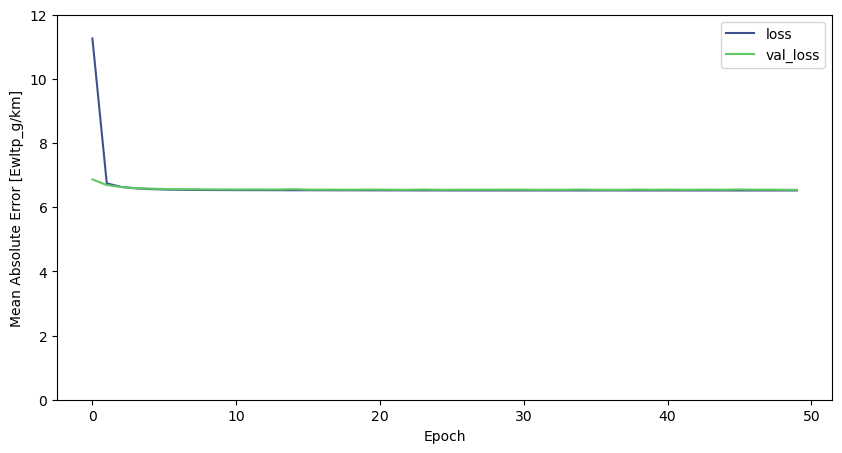

In [52]:
dl_plot_loss(training_history_linear_model)

### 3.2.3 Print results

In [53]:
dl_linear_model_eval = get_evaluation_table(dl_linear_model,X_train_dl, X_test_dl, y_train_dl, y_test_dl)
display(dl_linear_model_eval)

9936/9936 [==============================] - 14s 1ms/step


,Training Set,Test Set,Delta
MSE,85.627075,85.828949,0.201873
RMSE,9.253490,9.264391,0.010902
MAE,6.525137,6.522453,-0.002685
R2 Score,0.905169,0.904437,-0.000732


### 3.2.4 Plot Feature Weights

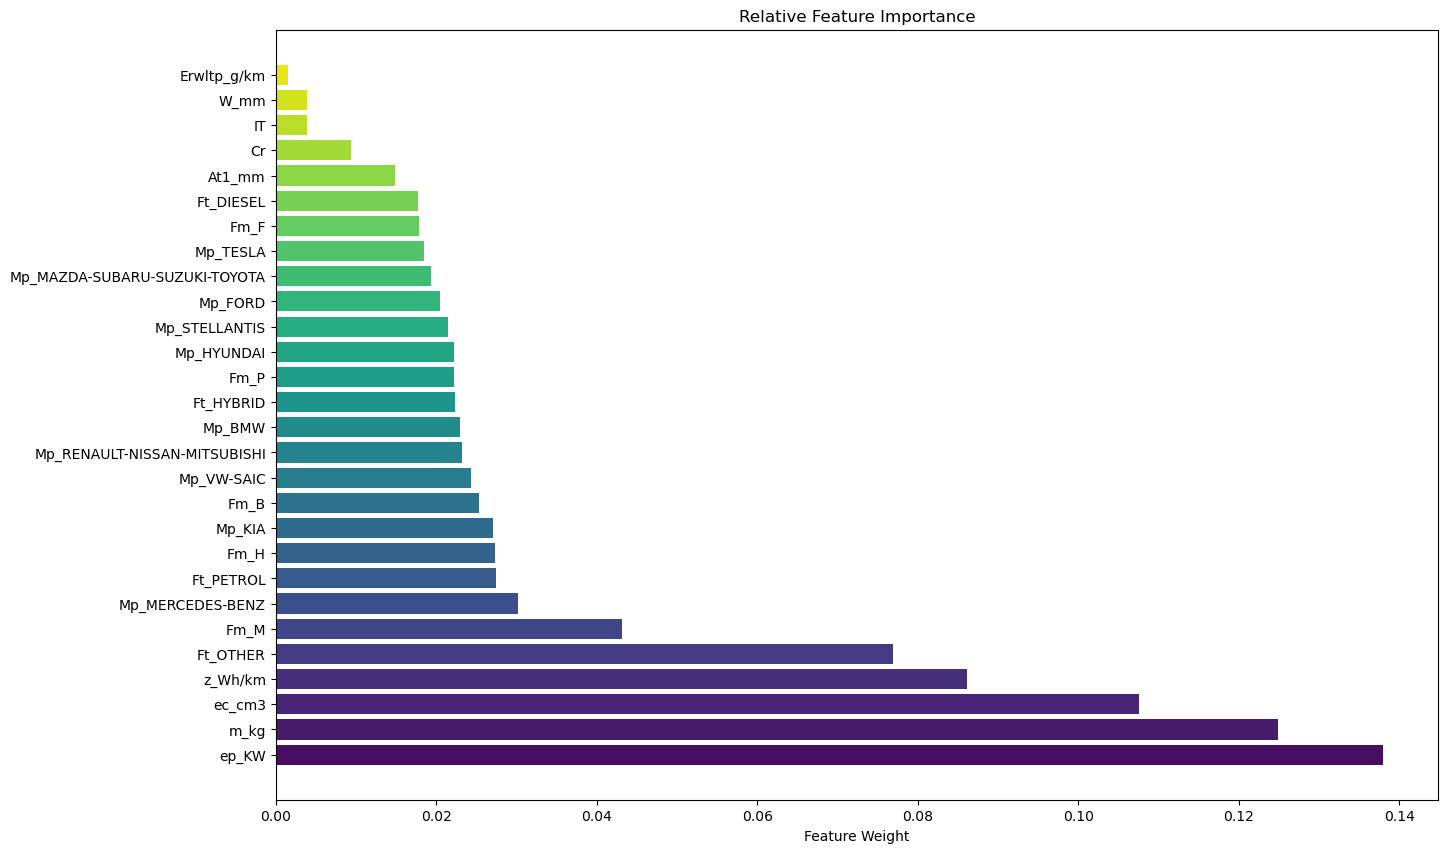

In [54]:
plot_feature_weights(dl_linear_model,data.columns)

## 3.3 DNN Model

### 3.3.1 Built Model

In [55]:
if train_models:
    'Step 1: Load the packages'
    # Done above
    
    'Step 2: Initialize the input layer'
    inputs = Input(shape = X_train_dl.shape[1], name = "Input")
    
    'Step 3: Initialize the layers'
    dense1 = Dense(units = 64,activation = "relu", name = "Dense_1")
    dense2 = Dense(units = 64,activation = "relu", name = "Dense_2")
    predict = Dense(units = 1,activation = "linear",name = "predict") # use linear activation function for regression, alternative: tanh
    
    'Step 4: Apply the layers one by one (functional construction' 
    x = dense1(inputs)
    x = dense2(x)
    outputs = predict(x)
    
    'Step 5: Finalize model and show structure'
    dnn_model = Model(inputs = inputs, outputs = outputs)
    dnn_model.summary()
    
    'Step 6: Compile Model with optimizer, loss and metrics'
    opt = tf.optimizers.Adam(learning_rate=0.001)
    dnn_model.compile(loss = "mean_absolute_error",
                  optimizer = opt)
    
    training_history_dnn = dnn_model.fit(X_train_dl, 
                                        y_train_dl,
                                        epochs=40, 
                                        batch_size=32,
                                        validation_split=0.2)
    'Step 7: Save Model'
    dump(dnn_model, '../models/dnn_model_2.joblib')

    'Step 8: Save training history'
    with open('../models/training_history_dnn_model_2', 'wb') as file:
        pickle.dump(training_history_dnn, file)

else:
  print("Only load model. Change variable train_models to True in chapter 1.0 if you want to retrain model.")

# Load model
# dnn_model: learning rate = 0.001, epochs = 15
dnn_model = load('../models/dnn_model_2.joblib')

# Load Training History
with open('../models/training_history_dnn_model_2', 'rb') as file:
    training_history_dnn_model = pickle.load(file)

Only load model. Change variable train_models to True in chapter 1.0 if you want to retrain model.


In [56]:
dnn_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 28)]              0         
                                                                 
 Dense_1 (Dense)             (None, 64)                1856      
                                                                 
 Dense_2 (Dense)             (None, 64)                4160      
                                                                 
 predict (Dense)             (None, 1)                 65        
                                                                 
Total params: 6081 (23.75 KB)
Trainable params: 6081 (23.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 3.3.2 Plot Loss

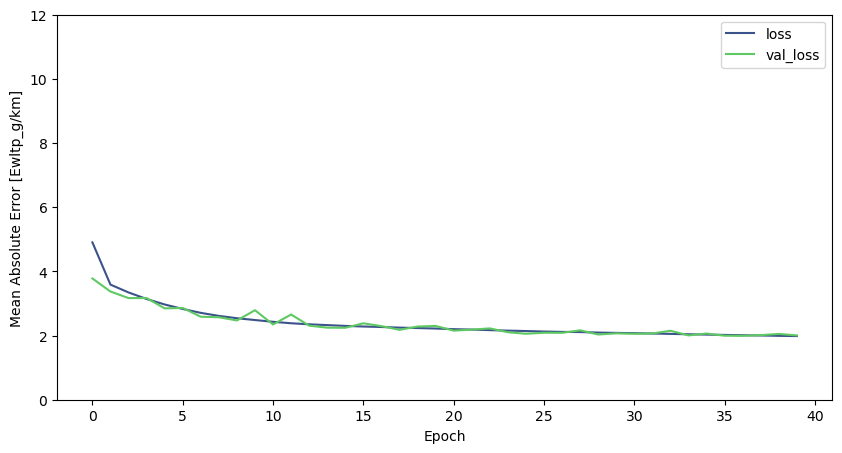

In [57]:
dl_plot_loss(training_history_dnn_model)

### 3.3.3 Print results

In [58]:
dnn_model_eval = get_evaluation_table(dnn_model,X_train_dl, X_test_dl, y_train_dl, y_test_dl)
display(dnn_model_eval)

9936/9936 [==============================] - 15s 1ms/step


,Training Set,Test Set,Delta
MSE,10.354631,10.447373,0.092742
RMSE,3.217861,3.232240,0.014378
MAE,1.992995,1.996871,0.003875
R2 Score,0.988532,0.988368,-0.000165


In [59]:
# save dataframe as csv
# dnn_model_eval.to_csv('results/tables/results_dnn_wo_fc.csv', index=True, sep=';',float_format='%.3f')

In [60]:
# Store results with pickle for streamlit import
with open('../models/results_dnnr.pkl', 'wb') as f:
    pickle.dump(dnn_model_eval.round(2), f)

In [61]:
# Predict Train and Test Set
y_pred_dnn_train_optimized = dnn_model.predict(X_train_dl)
y_pred_dnn_test_optimized = dnn_model.predict(X_test_dl)

# Compare results with dummy regressor
results_dnn = {
    'Model': ['DNN'],
    'RMSE (Train)': [np.sqrt(mean_squared_error(y_train_dl, y_pred_dnn_train_optimized))],
    'RMSE (Test)': [np.sqrt(mean_squared_error(y_test_dl, y_pred_dnn_test_optimized))],
    'MSE (Train)': [mean_squared_error(y_train_dl, y_pred_dnn_train_optimized)],
    'MSE (Test)': [mean_squared_error(y_test_dl, y_pred_dnn_test_optimized)],
    'MAE (Train)': [mean_absolute_error(y_train_dl, y_pred_dnn_train_optimized)],
    'MAE (Test)': [mean_absolute_error(y_test_dl, y_pred_dnn_test_optimized)],
    'R^2 (Train)': [r2_score(y_train_dl, y_pred_dnn_train_optimized)],
    'R^2 (Test)': [r2_score(y_test_dl, y_pred_dnn_test_optimized)]
}

# Format Evaluation Table
results_dnn = pd.DataFrame(results_dnn)
results_dnn=results_dnn.set_index(['Model'])

# Calculate Difference between test and train metrics
results_dnn["RMSE (Test-Train)"] = results_dnn["RMSE (Test)"] - results_dnn["RMSE (Train)"]
results_dnn["MSE (Test-Train)"] = results_dnn["MSE (Test)"] - results_dnn["MSE (Train)"]
results_dnn["MAE (Test-Train)"] = results_dnn["MAE (Test)"] - results_dnn["MAE (Train)"]
results_dnn["R^2 (Train-Test)"] = results_dnn["R^2 (Train)"] - results_dnn["R^2 (Test)"]

results_combined = pd.concat([results_combined,results_dnn])

  125/39744 [..............................] - ETA: 1:38

9936/9936 [==============================] - 13s 1ms/step


# 4 Compare Regression Models

In [62]:
results_combined

,RMSE (Train),RMSE (Test),RMSE (Test-Train),MSE (Train),MSE (Test),MSE (Test-Train),MAE (Train),MAE (Test),MAE (Test-Train),R^2 (Train),R^2 (Test),R^2 (Train-Test)
Model,,,,,,,,,,,,
XGBoost Regressor,1.320093,1.370622,0.050529,1.742647,1.878606,0.135959,0.736262,0.741925,0.005663,0.998070,9.979083e-01,1.617020e-04
XGBoost Regressor (w\o fc),2.048677,2.074915,0.026238,4.197077,4.305273,0.108196,1.288503,1.289756,0.001254,0.995352,9.952064e-01,1.453278e-04
Decision Tree Regressor,0.814874,0.894666,0.079791,0.664020,0.800427,0.136407,0.393240,0.405307,0.012067,0.999265,9.991088e-01,1.558109e-04
Decision Tree Regressor (w\o fc),1.620780,1.666913,0.046132,2.626929,2.778597,0.151668,0.930077,0.937710,0.007633,0.997091,9.969063e-01,1.844307e-04
Random Forest Regressor,0.824856,0.893725,0.068870,0.680387,0.798745,0.118358,0.396569,0.406699,0.010130,0.999246,9.991107e-01,1.358121e-04
Random Forest Regressor (w\o fc),1.624562,1.663579,0.039018,2.639201,2.767497,0.128295,0.932556,0.938309,0.005754,0.997077,9.969186e-01,1.584795e-04
Naive Regressor,30.048950,29.968921,-0.080029,902.939401,898.136239,-4.803162,18.870183,18.830497,-0.039687,0.000000,-5.477492e-07,5.477492e-07
Naive Regressor (w\o fc),30.048950,29.968921,-0.080029,902.939401,898.136239,-4.803162,18.870183,18.830497,-0.039687,0.000000,-5.477492e-07,5.477492e-07
DNN,3.217861,3.232240,0.014378,10.354631,10.447373,0.092742,1.992995,1.996871,0.003875,0.988532,9.883677e-01,1.645950e-04


In [63]:
# Get the RMSE, MAE and R Squared for the four models, which we want to compare as well as the Naive Regressor
results_baseline = results_combined.iloc[[3,5,1,8,7],[1,2,7,8,10,11]]

# results_baseline.to_csv('results/tables/results_baseline_models.csv', index=True, sep=';',float_format='%.3f')
display(results_baseline)

,RMSE (Test),RMSE (Test-Train),MAE (Test),MAE (Test-Train),R^2 (Test),R^2 (Train-Test)
Model,,,,,,
Decision Tree Regressor (w\o fc),1.666913,0.046132,0.937710,0.007633,9.969063e-01,1.844307e-04
Random Forest Regressor (w\o fc),1.663579,0.039018,0.938309,0.005754,9.969186e-01,1.584795e-04
XGBoost Regressor (w\o fc),2.074915,0.026238,1.289756,0.001254,9.952064e-01,1.453278e-04
DNN,3.232240,0.014378,1.996871,0.003875,9.883677e-01,1.645950e-04
Naive Regressor (w\o fc),29.968921,-0.080029,18.830497,-0.039687,-5.477492e-07,5.477492e-07


# 5 Hyperparameter Tuning

## 5.1 Randomized Search

In [64]:
# Hyperparameter Optimization
if train_models:

  # Set up rf and parameter distribution for Random Search
  rf = RandomForestRegressor(random_state=123)

  param_dist = {
      'n_estimators': randint(10, 200),
      'max_features': ['auto', 'sqrt', 'log2'],
      'max_depth': randint(1, 20),
      'min_samples_split': randint(2, 20),
      'min_samples_leaf': randint(1, 20),
      'bootstrap': [True, False]
  }

  # Fit Random Search
  random_search = RandomizedSearchCV(rf,param_distributions=param_dist,n_iter=10,cv=5,scoring='neg_mean_squared_error',n_jobs=-1,random_state=42)
  random_search.fit(X_train_wo_fc, y_train_wo_fc)

  # Save model
  dump(random_search, '../models/random_search.joblib')

else:
  print("Only load model. Change variable train_models to True in chapter 1.0 if you want to retrain model.")

# Load model
random_search = load('../models/random_search.joblib')

Only load model. Change variable train_models to True in chapter 1.0 if you want to retrain model.


### 4.1.1 Train optimized model

In [65]:
# Print Parameters of optimized model
print("Best Parameters:", random_search.best_params_)

# Get the best model
rf_optimized_random = random_search.best_estimator_

Best Parameters: {'bootstrap': True, 'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 131}


### 4.1.2 Show results

In [66]:
# Predict Train and Test Set
y_pred_rf_train_optimized = rf_optimized_random.predict(X_train_wo_fc)
y_pred_rf_test_optimized = rf_optimized_random.predict(X_test_wo_fc)

# Compare results with dummy regressor
results_rf_optimized = {
    'Model': ['Random Forest Regressor (Random Search)'],
    'RMSE (Train)': [np.sqrt(mean_squared_error(y_train_wo_fc, y_pred_rf_train_optimized))],
    'RMSE (Test)': [np.sqrt(mean_squared_error(y_test_wo_fc, y_pred_rf_test_optimized))],
    'MSE (Train)': [mean_squared_error(y_train_wo_fc, y_pred_rf_train_optimized)],
    'MSE (Test)': [mean_squared_error(y_test_wo_fc, y_pred_rf_test_optimized)],
    'MAE (Train)': [mean_absolute_error(y_train_wo_fc, y_pred_rf_train_optimized)],
    'MAE (Test)': [mean_absolute_error(y_test_wo_fc, y_pred_rf_test_optimized)],
    'R^2 (Train)': [r2_score(y_train_wo_fc, y_pred_rf_train_optimized)],
    'R^2 (Test)': [r2_score(y_test_wo_fc, y_pred_rf_test_optimized)]
}

# Format Evaluation Table
results_rf_optimized = pd.DataFrame(results_rf_optimized)
results_rf_optimized=results_rf_optimized.set_index(['Model'])

# Calculate Difference between test and train metrics
results_rf_optimized["RMSE (Test-Train)"] = results_rf_optimized["RMSE (Test)"] - results_rf_optimized["RMSE (Train)"]
results_rf_optimized["MSE (Test-Train)"] = results_rf_optimized["MSE (Test)"] - results_rf_optimized["MSE (Train)"]
results_rf_optimized["MAE (Test-Train)"] = results_rf_optimized["MAE (Test)"] - results_rf_optimized["MAE (Train)"]
results_rf_optimized["R^2 (Train-Test)"] = results_rf_optimized["R^2 (Train)"] - results_rf_optimized["R^2 (Test)"]

In [67]:
results_final = pd.concat([results_combined,results_rf_optimized])
display(results_final.iloc[[4,5,9,7],[1,2,10,11]])

,RMSE (Test),RMSE (Test-Train),R^2 (Test),R^2 (Train-Test)
Model,,,,
Random Forest Regressor,0.893725,0.068870,9.991107e-01,1.358121e-04
Random Forest Regressor (w\o fc),1.663579,0.039018,9.969186e-01,1.584795e-04
Random Forest Regressor (Random Search),2.327529,0.018699,9.939682e-01,1.281043e-04
Naive Regressor (w\o fc),29.968921,-0.080029,-5.477492e-07,5.477492e-07


## 5.2 GridSearch

In [68]:
# Hyperparameter Optimization

if train_models:

    param_grid = {
        'n_estimators': [50, 100, 150, 200],
        'max_depth': [None, 10, 20],
        'random_state': [123],
        'criterion': ['squared_error'] # this is the default (Mean squared error)
    }

    rf_grid = RandomForestRegressor()

    # Create the grid search
    grid_search = GridSearchCV(estimator=rf_grid, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

    # Fit the grid search to the data
    grid_search.fit(X_train_wo_fc, y_train_wo_fc)

    # Save model
    dump(grid_search, '../models/grid_search.joblib')

else:
  print("Only load model. Change variable train_models to True in chapter 1.0 if you want to retrain model.")

# Load model
grid_search = load('../models/grid_search.joblib')

Only load model. Change variable train_models to True in chapter 1.0 if you want to retrain model.


In [69]:
# Print Parameters of optimized model
print("Best Parameters:", grid_search.best_params_)

# Get the best model
rf_optimized_grid = grid_search.best_estimator_

Best Parameters: {'criterion': 'squared_error', 'max_depth': None, 'n_estimators': 200, 'random_state': 123}


In [70]:
# Predict Train and Test Set
y_pred_rf_train_optimized = rf_optimized_grid.predict(X_train_wo_fc)
y_pred_rf_test_optimized = rf_optimized_grid.predict(X_test_wo_fc)

# Compare results with dummy regressor
results_rf_optimized_grid = {
    'Model': ['Random Forest Regressor (Grid Search)'],
    'RMSE (Train)': [np.sqrt(mean_squared_error(y_train_wo_fc, y_pred_rf_train_optimized))],
    'RMSE (Test)': [np.sqrt(mean_squared_error(y_test_wo_fc, y_pred_rf_test_optimized))],
    'MSE (Train)': [mean_squared_error(y_train_wo_fc, y_pred_rf_train_optimized)],
    'MSE (Test)': [mean_squared_error(y_test_wo_fc, y_pred_rf_test_optimized)],
    'MAE (Train)': [mean_absolute_error(y_train_wo_fc, y_pred_rf_train_optimized)],
    'MAE (Test)': [mean_absolute_error(y_test_wo_fc, y_pred_rf_test_optimized)],
    'R^2 (Train)': [r2_score(y_train_wo_fc, y_pred_rf_train_optimized)],
    'R^2 (Test)': [r2_score(y_test_wo_fc, y_pred_rf_test_optimized)]
}

# Format Evaluation Table
results_rf_optimized_grid = pd.DataFrame(results_rf_optimized_grid)
results_rf_optimized_grid = results_rf_optimized_grid.set_index(['Model'])

# Calculate Difference between test and train metrics
results_rf_optimized_grid["RMSE (Test-Train)"] = results_rf_optimized_grid["RMSE (Test)"] - results_rf_optimized_grid["RMSE (Train)"]
results_rf_optimized_grid["MSE (Test-Train)"] = results_rf_optimized_grid["MSE (Test)"] - results_rf_optimized_grid["MSE (Train)"]
results_rf_optimized_grid["MAE (Test-Train)"] = results_rf_optimized_grid["MAE (Test)"] - results_rf_optimized_grid["MAE (Train)"]
results_rf_optimized_grid["R^2 (Train-Test)"] = results_rf_optimized_grid["R^2 (Train)"] - results_rf_optimized_grid["R^2 (Test)"]

In [71]:
# Store predictions for streamlit
with open('../models/y_pred_rf_optimized_test.pkl', 'wb') as f:
    pickle.dump(y_pred_rf_test_optimized, f)
with open('../models/y_pred_rf_optimized_train.pkl', 'wb') as f:
    pickle.dump(y_pred_rf_train_optimized, f)

In [72]:
results_final = pd.concat([results_final,results_rf_optimized_grid])

## 5.3 Results of Hyperparameter Tuning

In [73]:
results_hyperparamter_tuning = results_final.iloc[[5,9,10,7],[1,2,7,8,10,11]]
# results_hyperparamter_tuning.to_csv('results/tables/results_hyperparamter_tuning.csv', index=True, sep=';',float_format='%.4f')
display(results_hyperparamter_tuning)

,RMSE (Test),RMSE (Test-Train),MAE (Test),MAE (Test-Train),R^2 (Test),R^2 (Train-Test)
Model,,,,,,
Random Forest Regressor (w\o fc),1.663579,0.039018,0.938309,0.005754,9.969186e-01,1.584795e-04
Random Forest Regressor (Random Search),2.327529,0.018699,1.503755,0.001590,9.939682e-01,1.281043e-04
Random Forest Regressor (Grid Search),1.663310,0.038859,0.938240,0.005704,9.969196e-01,1.578792e-04
Naive Regressor (w\o fc),29.968921,-0.080029,18.830497,-0.039687,-5.477492e-07,5.477492e-07


In [74]:
# Store results with pickle for streamlit import
with open('../models/results_regression.pkl', 'wb') as f:
    pickle.dump(results_final, f)

# 6 Model Interpretation

## 6.1 Feature Importance

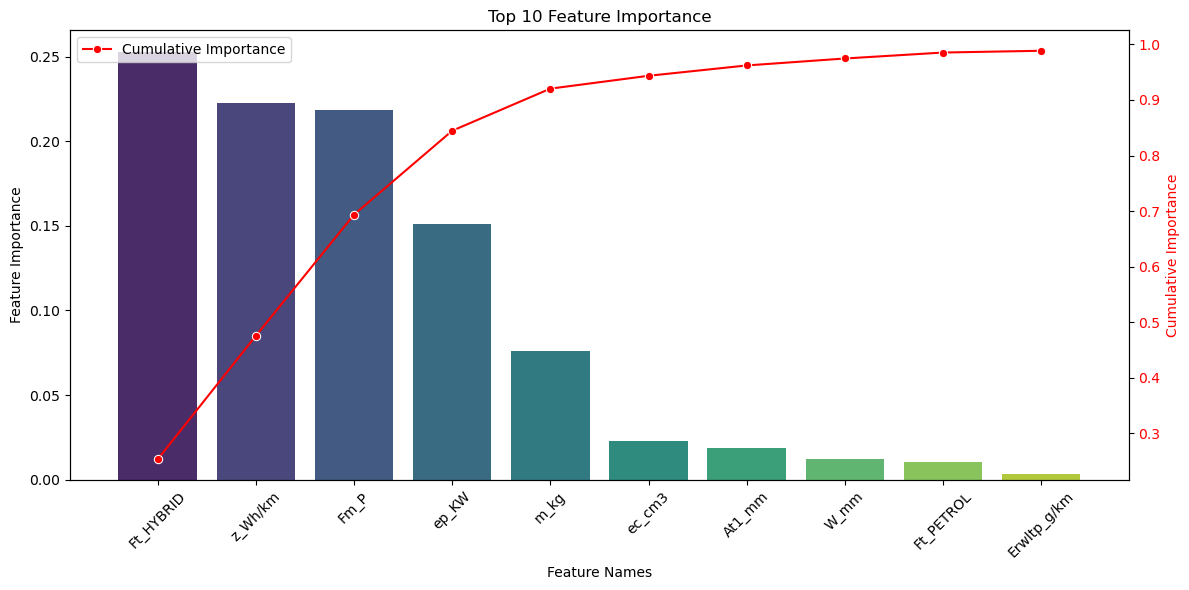

In [75]:
# Create dictionary to get top 10 features
feature_importances = dict(zip(X_train_wo_fc.columns, rf_optimized_grid.feature_importances_))
feature_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
top_10_features = feature_importances[:10]

# Extract feature names and importance from the dictionary of selected and sorted features 
feature_names, importance_values = zip(*top_10_features)

# Calculate cumulative feature importance
cumulative_importance = np.cumsum(importance_values)

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot feature importance 
sns.barplot(x=list(feature_names), y=list(importance_values), palette='viridis', ax=ax1)
ax1.set_xlabel('Feature Names')
ax1.set_ylabel('Feature Importance')
ax1.tick_params(axis='y')
ax1.set_title('Top 10 Feature Importance')
ax1.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

# Add the cumulative importance
ax2 = ax1.twinx()
sns.lineplot(x=list(feature_names), y=cumulative_importance, marker='o', sort=False, color='red', ax=ax2)
ax2.set_ylabel('Cumulative Importance', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Show legend
ax2.legend(["Cumulative Importance"])
plt.tight_layout()
plt.show()

In [76]:
# Get the exact values 
print(feature_importances[:10])
print(cumulative_importance)

[('Ft_HYBRID', 0.25285919750318364), ('z_Wh/km', 0.22238491621663237), ('Fm_P', 0.2182255540162215), ('ep_KW', 0.15110443681658675), ('m_kg', 0.07584369542002145), ('ec_cm3', 0.02314822151403598), ('At1_mm', 0.01862128736524829), ('W_mm', 0.012540743577112856), ('Ft_PETROL', 0.01071426297476597), ('Erwltp_g/km', 0.0032094545826752913)]
[0.2528592  0.47524411 0.69346967 0.8445741  0.9204178  0.94356602
 0.96218731 0.97472805 0.98544232 0.98865177]


In [77]:
# Calculate the correlations
z_Wh_km_corr = np.corrcoef(X_train_wo_fc['z_Wh/km'], y_pred_rf_train_optimized)
ep_KW_corr = np.corrcoef(X_train_wo_fc['ep_KW'], y_pred_rf_train_optimized)
m_kg_corr = np.corrcoef(X_train_wo_fc['m_kg'], y_pred_rf_train_optimized)

# Print the correlations
print("Correlation between z_Wh/km and y_pred_rf_train_optimized:", z_Wh_km_corr[0,1])
print("Correlation between ep_KW and y_pred_rf_train_optimized:", ep_KW_corr[0,1])
print("Correlation between m_kg and y_pred_rf_train_optimized:", m_kg_corr[0,1])


Correlation between z_Wh/km and y_pred_rf_train_optimized: -0.7931394825040234
Correlation between ep_KW and y_pred_rf_train_optimized: 0.00924597529840795
Correlation between m_kg and y_pred_rf_train_optimized: -0.23553729467358253


## 6.2 Visualize relationship of predictions to the most important features
We can explain these results visually by plotting boxplots and scatterplots

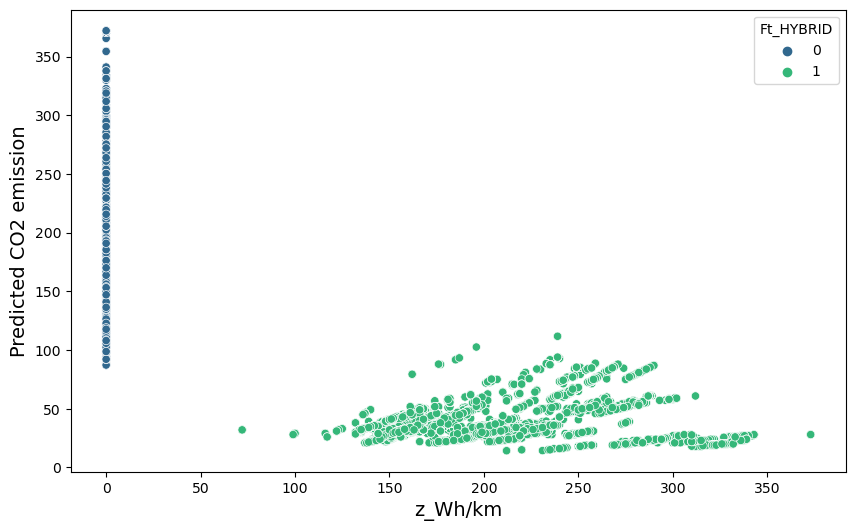

In [78]:
# Create scatterplot using Seaborn
plt.figure(figsize=(10, 6))  # Set figure size
sns.scatterplot(x=X_train_wo_fc['z_Wh/km'], y=y_pred_rf_train_optimized, hue=X_train_wo_fc['Ft_HYBRID'], palette='viridis')

# Set plot title and labels
plt.xlabel('z_Wh/km', fontsize=14)
plt.ylabel('Predicted CO2 emission', fontsize=14)

# Show the plot
plt.show()

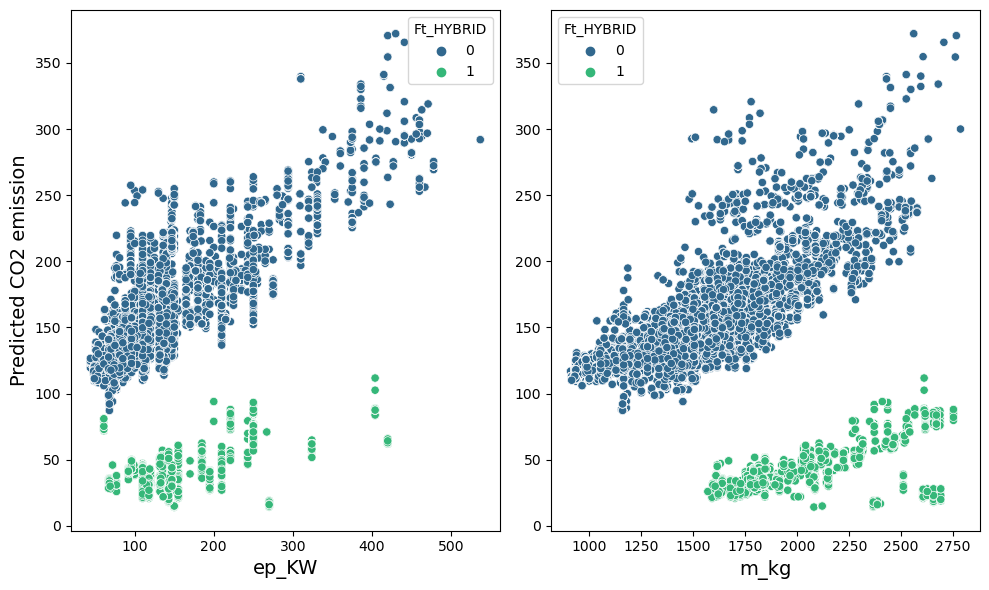

In [79]:
# Create a figure and two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))  # 1 row, 2 columns

# Plot the first scatterplot on the first subplot
sns.scatterplot(x=X_train_wo_fc['ep_KW'], y=y_pred_rf_train_optimized, 
                hue=X_train_wo_fc['Ft_HYBRID'], palette='viridis', ax=axes[0])

# Set title and labels for the first subplot
axes[0].set_xlabel('ep_KW', fontsize=14)
axes[0].set_ylabel('Predicted CO2 emission', fontsize=14)

# Plot the second scatterplot on the second subplot
sns.scatterplot(x=X_train_wo_fc['m_kg'], y=y_pred_rf_train_optimized, 
                hue=X_train_wo_fc['Ft_HYBRID'], palette='viridis', ax=axes[1])

# Set title and labels for the second subplot
axes[1].set_xlabel('m_kg', fontsize=14)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the combined plot
plt.show()

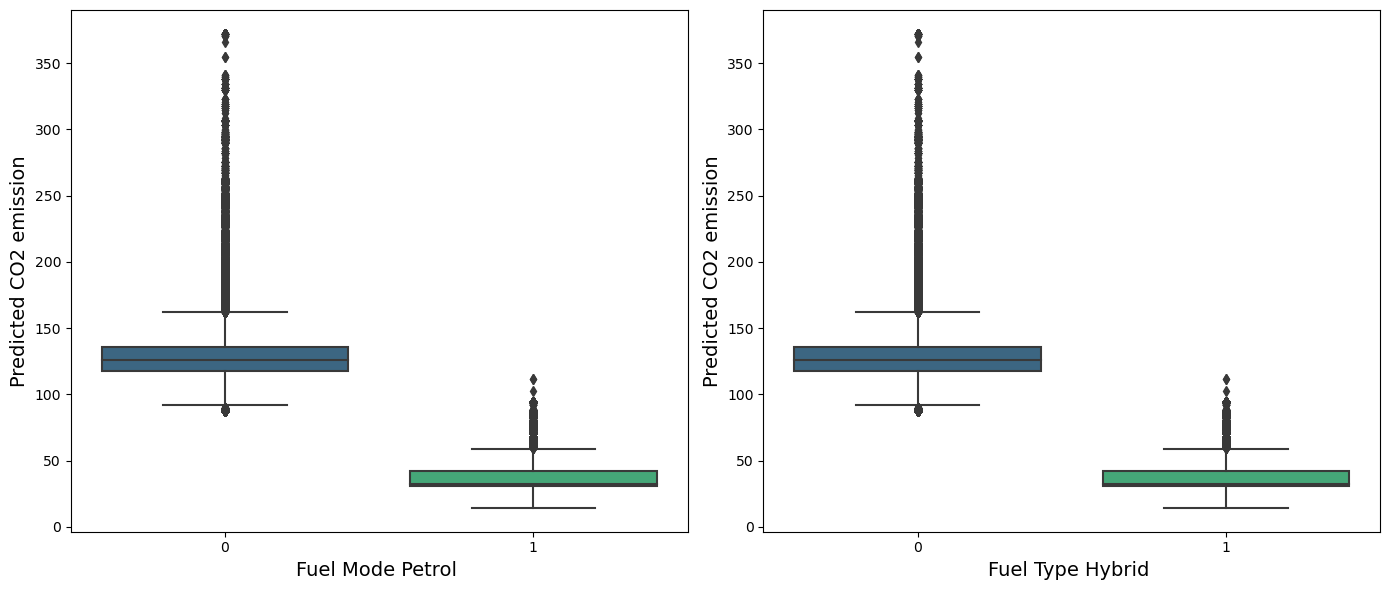

In [80]:
plt.figure(figsize=(14, 6))  

# Boxplot for Fm_P on the left side
plt.subplot(1, 2, 1)
sns.boxplot(x=X_train_wo_fc['Fm_P'], y=y_pred_rf_train_optimized, palette='viridis')
plt.xlabel('Fuel Mode Petrol ', fontsize=14)
plt.ylabel('Predicted CO2 emission', fontsize=14)

# Boxplot for ep_KW on the right side
plt.subplot(1, 2, 2)
sns.boxplot(x=X_train_wo_fc['Ft_HYBRID'], y=y_pred_rf_train_optimized, palette='viridis')
plt.xlabel('Fuel Type Hybrid ', fontsize=14)
plt.ylabel('Predicted CO2 emission', fontsize=14)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

## 6.3 SHAP values

Initially we wanted to use the SHAP library for the model interpretation, because the summary_plot is very convienient and informative. However, we let the following code run for over 72h and then decided to stop it and use feature importance instead. 

In [81]:
'Code is commented out, because the running time is too long'

# %pip install shap
# import shap
# 
# # Create a SHAP explainer object
# explainer = shap.TreeExplainer(rf_optimized_grid)
# 
# # Calculate SHAP values
# shap_values = explainer.shap_values(X_test_wo_fc)
# 
# # Plot SHAP summary plot
# shap.summary_plot(shap_values, X_test_wo_fc)
# 
# # Save the model
# with open('interpretation/rf_optimized_grid.pkl', 'wb') as f:
#     pickle.dump(rf_optimized_grid, f)
# 
# # Save SHAP values
# with open('interpretation/shap_values.pkl', 'wb') as f:
#     pickle.dump(shap_values, f)
# 
# # Load the model
# with open('interpretation/rf_optimized_grid.pkl', 'rb') as f:
#     rf_optimized_grid = pickle.load(f)
# explainer = shap.TreeExplainer(rf_optimized_grid)
# 
# # Load SHAP values
# with open('interpretation/shap_values.pkl', 'rb') as f:
#     shap_values = pickle.load(f)
# 
# # Plot SHAP summary plot
# shap.summary_plot(shap_values, X_test_wo_fc)

'Code is commented out, because the running time is too long'

# 7 Streamlit 

In the following code, I will preprocess some tables and graphs, which I can load into the streamlit presentation. It is necessary to load some of the results in streamlit, instead of calculating it on the spot, because some of the code is really computational expensive and would take too long to run during the presentation.

## 7.1 Models

In [116]:
# safe rf_optimized_random model for streamlit
dump(grid_search, '../presentation/streamlit_saved_files/grid_search_r.joblib')
dump(random_search, '../presentation/streamlit_saved_files/random_search_r.joblib')

['../presentation/streamlit_saved_files/random_search_r.joblib']

In [115]:
random_search.best_estimator_

RandomForestRegressor(max_depth=15, max_features='log2', min_samples_leaf=8,
                      min_samples_split=8, n_estimators=131, random_state=123)

## 7.2 Results tables

In [ ]:
# Store results with pickle for streamlit import
with open('../presentation/streamlit_saved_files/results_rfr.pkl', 'wb') as f:
    pickle.dump(results_rf_wo_fc, f)

In [93]:
results_combined

,RMSE (Train),RMSE (Test),RMSE (Test-Train),MSE (Train),MSE (Test),MSE (Test-Train),MAE (Train),MAE (Test),MAE (Test-Train),R^2 (Train),R^2 (Test),R^2 (Train-Test)
Model,,,,,,,,,,,,
XGBoost Regressor,1.320093,1.370622,0.050529,1.742647,1.878606,0.135959,0.736262,0.741925,0.005663,0.998070,9.979083e-01,1.617020e-04
XGBoost Regressor (w\o fc),2.048677,2.074915,0.026238,4.197077,4.305273,0.108196,1.288503,1.289756,0.001254,0.995352,9.952064e-01,1.453278e-04
Decision Tree Regressor,0.814874,0.894666,0.079791,0.664020,0.800427,0.136407,0.393240,0.405307,0.012067,0.999265,9.991088e-01,1.558109e-04
Decision Tree Regressor (w\o fc),1.620780,1.666913,0.046132,2.626929,2.778597,0.151668,0.930077,0.937710,0.007633,0.997091,9.969063e-01,1.844307e-04
Random Forest Regressor,0.824856,0.893725,0.068870,0.680387,0.798745,0.118358,0.396569,0.406699,0.010130,0.999246,9.991107e-01,1.358121e-04
Random Forest Regressor (w\o fc),1.624562,1.663579,0.039018,2.639201,2.767497,0.128295,0.932556,0.938309,0.005754,0.997077,9.969186e-01,1.584795e-04
Naive Regressor,30.048950,29.968921,-0.080029,902.939401,898.136239,-4.803162,18.870183,18.830497,-0.039687,0.000000,-5.477492e-07,5.477492e-07
Naive Regressor (w\o fc),30.048950,29.968921,-0.080029,902.939401,898.136239,-4.803162,18.870183,18.830497,-0.039687,0.000000,-5.477492e-07,5.477492e-07
DNN,3.217861,3.232240,0.014378,10.354631,10.447373,0.092742,1.992995,1.996871,0.003875,0.988532,9.883677e-01,1.645950e-04


In [111]:
regression_model_selection = results_combined.iloc[[3,5,1,8,7],[1,2,7,8,10]]
regression_model_selection = regression_model_selection.rename(columns={'MAE (Test-Train)': 'Δ MAE', 'RMSE (Test-Train)': 'Δ RMSE', 'R^2 (Test)': 'R\u00B2 (Test)'},
                                                               index={'Decision Tree Regressor (w\o fc)':'Decision Tree Regressor','Random Forest Regressor (w\o fc)':'Random Forest Regressor','XGBoost Regressor (w\o fc)':'XGBoost Regressor','Naive Regressor (w\o fc)':'Naive Regressor'})
display(regression_model_selection)

# Save results as df for streamlit
with open('../presentation/streamlit_saved_files/regression_model_selection_results.pkl', 'wb') as f:
    pickle.dump(regression_model_selection, f)

,RMSE (Test),Δ RMSE,MAE (Test),Δ MAE,R² (Test)
Model,,,,,
Decision Tree Regressor,1.666913,0.046132,0.937710,0.007633,9.969063e-01
Random Forest Regressor,1.663579,0.039018,0.938309,0.005754,9.969186e-01
XGBoost Regressor,2.074915,0.026238,1.289756,0.001254,9.952064e-01
DNN,3.232240,0.014378,1.996871,0.003875,9.883677e-01
Naive Regressor,29.968921,-0.080029,18.830497,-0.039687,-5.477492e-07


In [109]:
# Hyperparameter Tuning
regression_hyperparameter_tuning_results = results_hyperparamter_tuning.iloc[0:3,:5]
regression_hyperparameter_tuning_results = regression_hyperparameter_tuning_results.rename(columns={'MAE (Test-Train)': 'Δ MAE', 'RMSE (Test-Train)': 'Δ RMSE', 'R^2 (Test)': 'R\u00B2 (Test)'},
                                                               index={'Random Forest Regressor (w\o fc)':'Random Forest Regressor'})
display(regression_hyperparameter_tuning_results)

# Save table as df for streamlit
with open('../presentation/streamlit_saved_files/regression_hyperparameter_tuning_results.pkl', 'wb') as f:
    pickle.dump(regression_hyperparameter_tuning_results, f)


,RMSE (Test),Δ RMSE,MAE (Test),Δ MAE,R² (Test)
Model,,,,,
Random Forest Regressor,1.663579,0.039018,0.938309,0.005754,0.996919
Random Forest Regressor (Random Search),2.327529,0.018699,1.503755,0.001590,0.993968
Random Forest Regressor (Grid Search),1.663310,0.038859,0.938240,0.005704,0.996920


## 7.3 Graphs

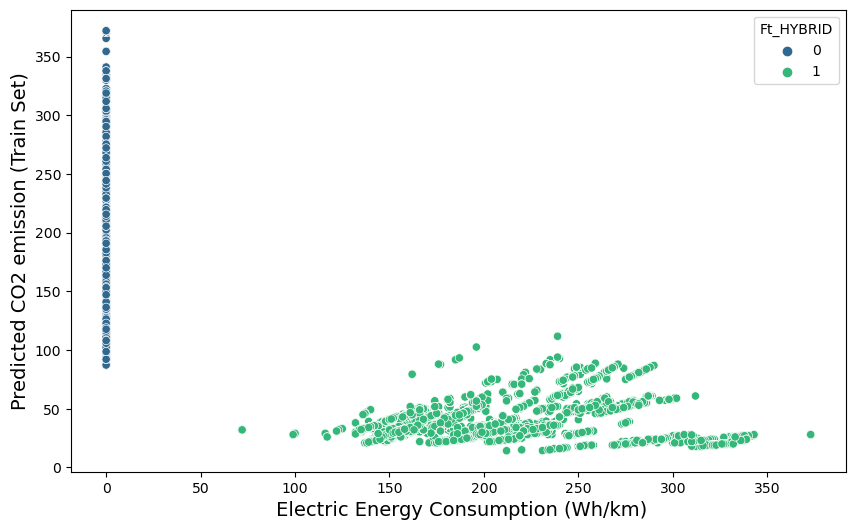

In [83]:
# Create scatterplot using Seaborn
plt.figure(figsize=(10, 6))  # Set figure size
sns.scatterplot(x=X_train_wo_fc['z_Wh/km'], y=y_pred_rf_train_optimized, hue=X_train_wo_fc['Ft_HYBRID'], palette='viridis')

# Set plot title and labels
plt.xlabel(' Electric Energy Consumption (Wh/km)', fontsize=14)
plt.ylabel('Predicted CO2 emission (Train Set)', fontsize=14)

# Show and safe the plot
plt.savefig('../presentation/plots/interpretation_scatterplot_z.png')
plt.show()

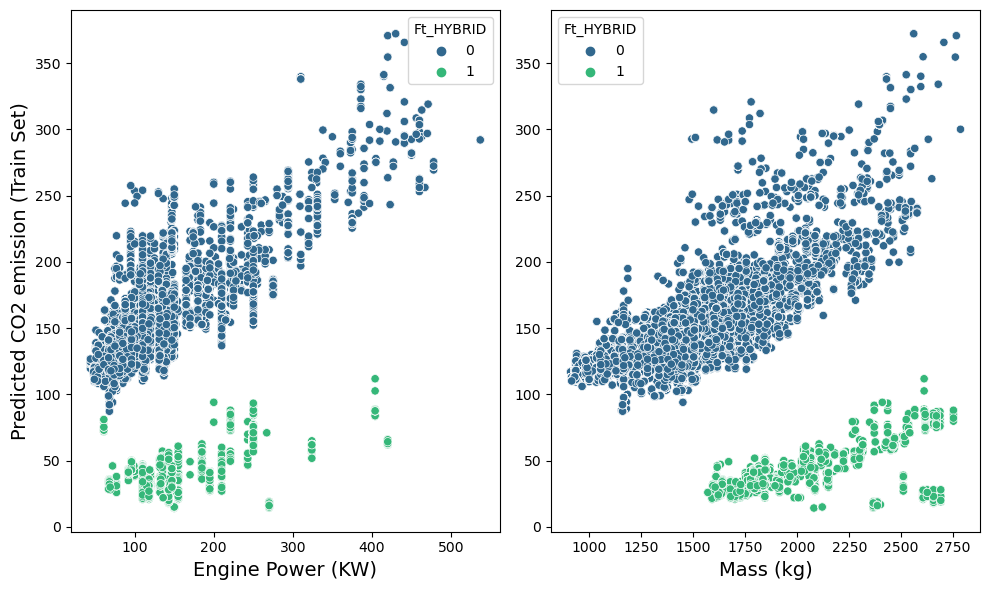

In [84]:
# Create a figure and two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))  # 1 row, 2 columns

# Plot the first scatterplot on the first subplot
sns.scatterplot(x=X_train_wo_fc['ep_KW'], y=y_pred_rf_train_optimized, 
                hue=X_train_wo_fc['Ft_HYBRID'], palette='viridis', ax=axes[0])

# Set title and labels for the first subplot
axes[0].set_xlabel('Engine Power (KW)', fontsize=14)
axes[0].set_ylabel('Predicted CO2 emission (Train Set)', fontsize=14)

# Plot the second scatterplot on the second subplot
sns.scatterplot(x=X_train_wo_fc['m_kg'], y=y_pred_rf_train_optimized, 
                hue=X_train_wo_fc['Ft_HYBRID'], palette='viridis', ax=axes[1])

# Set title and labels for the second subplot
axes[1].set_xlabel('Mass (kg)', fontsize=14)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show and safe the combined plot
plt.savefig('../presentation/plots/interpretation_scatterplot_ep_m.png')
plt.show()